In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from google.colab import files
uploaded = files.upload()

Saving finaldata.csv to finaldata (4).csv


In [182]:
df=pd.read_csv("finaldata.csv")
df

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,100.16.135.233,5,5.0,5,4,9.865200e+03,1.135730e+04,0.250000
1,101.32.34.206,6,6.0,6,5,1.109425e+06,2.693437e+06,5.600000
2,101.89.239.238,1,1.0,1,1,8.249000e+05,0.000000e+00,0.000000
3,101.91.227.154,1,1.0,1,0,3.280000e+02,0.000000e+00,0.000000
4,103.152.221.226,1,1.0,1,1,2.131600e+05,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...
410,89.86.32.26,2,2.0,2,2,1.773600e+04,1.439669e+04,0.000000
411,91.183.152.182,12,12.0,12,9,6.282333e+03,8.599698e+03,0.363636
412,93.65.170.88,5,5.0,5,3,9.792800e+03,1.142108e+04,0.250000
413,94.231.255.203,5,5.0,5,4,9.865200e+03,1.135730e+04,0.000000


In [183]:
df.head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,100.16.135.233,5,5.0,5,4,9865.2,1.135730e+04,0.25
1,101.32.34.206,6,6.0,6,5,1109425.0,2.693437e+06,5.60
2,101.89.239.238,1,1.0,1,1,824900.0,0.000000e+00,0.00
3,101.91.227.154,1,1.0,1,0,328.0,0.000000e+00,0.00
4,103.152.221.226,1,1.0,1,1,213160.0,0.000000e+00,0.00


K-Means Algorithm (Using unsupervised learning)

In [184]:
df.columns

Index(['IP', 'Total Requests', 'Daily Mean', 'GET requests',
       'Successful requests', 'Mean Return Size', 'Return Size Std',
       'Mean Time Difference'],
      dtype='object')

In [185]:
chosen_data = df[['Total Requests', 'Daily Mean', 'GET requests',
       'Successful requests', 'Mean Return Size', 'Return Size Std',
       'Mean Time Difference']]

In [186]:
chosen_data.head()

,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,5,5.0,5,4,9865.2,1.135730e+04,0.25
1,6,6.0,6,5,1109425.0,2.693437e+06,5.60
2,1,1.0,1,1,824900.0,0.000000e+00,0.00
3,1,1.0,1,0,328.0,0.000000e+00,0.00
4,1,1.0,1,1,213160.0,0.000000e+00,0.00


In [187]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(chosen_data)
chosen_data = pd.DataFrame(np_scaled, columns=chosen_data.columns)

In [188]:
chosen_data.head()

,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,0.013746,0.027586,0.017123,0.013699,1.754720e-05,0.000051,0.000004
1,0.017182,0.034483,0.020548,0.017123,2.026899e-03,0.012014,0.000087
2,0.000000,0.000000,0.003425,0.003425,1.506953e-03,0.000000,0.000000
3,0.000000,0.000000,0.003425,0.000000,1.187819e-07,0.000000,0.000000
4,0.000000,0.000000,0.003425,0.003425,3.890510e-04,0.000000,0.000000


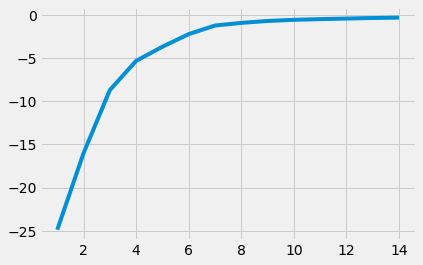

In [189]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(chosen_data) for i in n_cluster]
scores = [kmeans[i].score(chosen_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [190]:
cluster_model = kmeans[5]
df['cluster'] = cluster_model.predict(chosen_data)
df['cluster'].value_counts()

0    344
5     40
2     13
1     12
4      4
3      2
Name: cluster, dtype: int64

In [191]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(chosen_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 415 samples in 0.001s...
[t-SNE] Computed neighbors for 415 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 415 / 415
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.898361
[t-SNE] KL divergence after 500 iterations: 0.123611


In [192]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [193]:
tsne_cluster = df.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

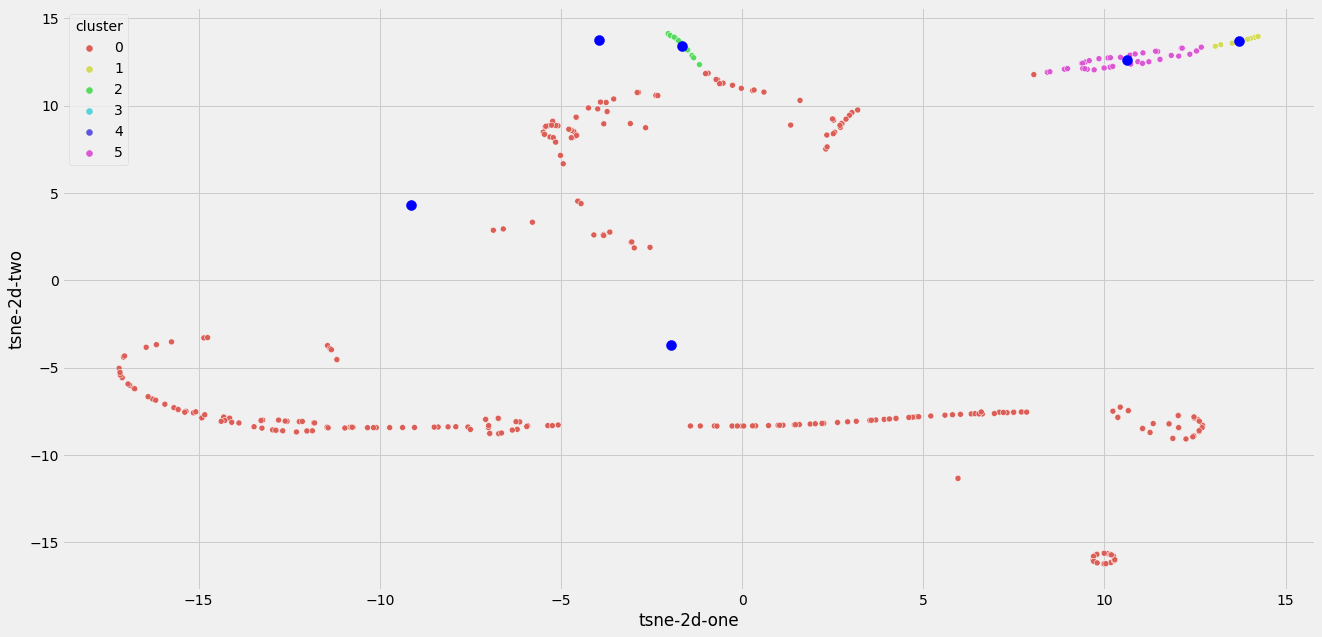

In [194]:
plt.figure(figsize=(20,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df,
    hue="cluster",
    palette=sns.color_palette("hls", 6),
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [195]:
centers = cluster_model.cluster_centers_
points = np.asarray(chosen_data)
total_distance = pd.Series(dtype='float64')


In [196]:
def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[chosen_data.columns])
    total_distance = pd.Series(dtype='float64')
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            distance += a**2
        total_distance.at[i]= distance
    
    return total_distance

In [197]:
df['ssd'] = get_sum_square_distance(chosen_data, cluster_model)

(array([ 15.,  14.,  94., 269.,   4.,   1.,   1.,   4.,   1.,   0.,   3.,
          0.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 4.49638151,  4.8052777 ,  5.11417389,  5.42307008,  5.73196627,
         6.04086246,  6.34975865,  6.65865484,  6.96755103,  7.27644722,
         7.58534341,  7.8942396 ,  8.20313579,  8.51203198,  8.82092817,
         9.12982436,  9.43872055,  9.74761674, 10.05651293, 10.36540912,
        10.67430531, 10.9832015 , 11.29209769, 11.60099388, 11.90989007,
        12.21878626, 12.52768245, 12.83657864, 13.14547483, 13.45437102,
        13.76326721, 14.0721634 , 14.38105959, 14.68995578, 14.99885197,
        15.30774816, 15.61664435, 15.92554054, 16.23443673, 16.54333292,
        16.85222911, 17.1611253 , 17.47002149, 17.77891768, 18.08781387,
 

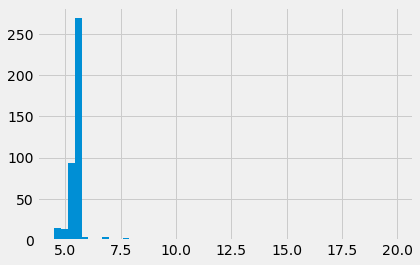

In [198]:
plt.hist(df['ssd'], bins=50)

In [199]:
cutoff = 7.5
df['anomaly_kmeans'] = (df['ssd'] >= cutoff).astype(int)

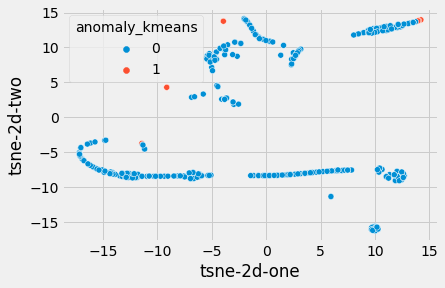

In [200]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    data=df,
    legend="full",
    alpha=1
)

In [201]:
df.loc[df['anomaly_kmeans']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
108,185.191.171.26,2,2.0,2,2,3.140000e+02,0.000000e+00,58759.000000,1,14.128437,13.909864,8.339868,1
125,195.191.163.28,7,7.0,7,6,7.846000e+07,2.075582e+08,661.166667,4,-9.146929,4.303019,8.750140,1
133,202.200.48.117,1,1.0,1,1,5.472215e+08,0.000000e+00,0.000000,0,-11.440982,-3.732212,11.160658,1
136,220.158.157.182,9,9.0,9,4,6.080910e+07,1.824047e+08,17.875000,4,-9.145062,4.293844,7.727056,1
139,27.65.252.148,6,6.0,6,5,9.153451e+07,2.241887e+08,13.400000,4,-9.151245,4.291281,9.567791,1
204,54.36.148.12,2,2.0,2,2,9.576500e+03,1.088732e+04,59506.000000,1,14.146562,13.919206,8.441850,1
227,54.36.148.17,292,146.0,292,292,1.292700e+04,1.491498e+04,306.278351,3,-3.936702,13.761462,19.941191,1
278,54.36.148.34,2,2.0,2,2,8.686500e+03,1.044750e+04,64051.000000,1,14.240026,13.967902,9.098096,1
336,54.36.149.52,2,2.0,2,2,1.224400e+04,1.296551e+04,55131.000000,1,14.026962,13.855875,7.867210,1
342,54.36.149.61,275,137.5,275,275,1.391965e+04,1.371706e+04,325.156934,3,-3.936007,13.763123,17.776789,1


In [202]:
df.loc[df['anomaly_kmeans']==0]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
0,100.16.135.233,5,5.0,5,4,9.865200e+03,1.135730e+04,0.250000,0,-5.465349,8.390544,5.315259,0
1,101.32.34.206,6,6.0,6,5,1.109425e+06,2.693437e+06,5.600000,0,-3.816341,8.966422,5.256598,0
2,101.89.239.238,1,1.0,1,1,8.249000e+05,0.000000e+00,0.000000,0,-14.853204,-3.295144,5.464533,0
3,101.91.227.154,1,1.0,1,0,3.280000e+02,0.000000e+00,0.000000,0,10.178643,-16.161877,5.472852,0
4,103.152.221.226,1,1.0,1,1,2.131600e+05,0.000000e+00,0.000000,0,-16.163691,-3.681581,5.464860,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,89.86.32.26,2,2.0,2,2,1.773600e+04,1.439669e+04,0.000000,0,-3.819349,2.573575,5.424129,0
411,91.183.152.182,12,12.0,12,9,6.282333e+03,8.599698e+03,0.363636,0,-2.895143,10.760445,5.091021,0
412,93.65.170.88,5,5.0,5,3,9.792800e+03,1.142108e+04,0.250000,0,-5.145535,7.919318,5.322711,0
413,94.231.255.203,5,5.0,5,4,9.865200e+03,1.135730e+04,0.000000,0,-4.782438,8.657574,5.315268,0


Isolated forests

In [203]:
outlier_fraction = 0.028
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=outlier_fraction, behaviour='new')

In [204]:
model.fit(chosen_data)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination=0.028,
                max_features=3, max_samples='auto', n_estimators=200, n_jobs=-1,
                random_state=42, verbose=0, warm_start=False)

In [205]:
df['anomaly_isolated'] = pd.Series(model.predict(chosen_data))

In [206]:
df['anomaly_isolated'] = df['anomaly_isolated'].map( {1: 0, -1: 1} )
df['anomaly_isolated'].value_counts()

0    403
1     12
Name: anomaly_isolated, dtype: int64

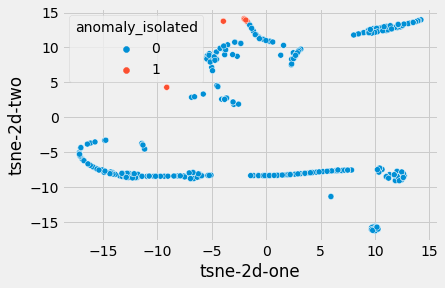

In [207]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    data=df,
    legend="full",
    alpha=1
)

In [208]:
df.loc[df['anomaly_isolated']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated
50,157.55.39.17,47,47.0,47,46,2.907660e+03,4.854550e+03,1638.521739,2,-1.831992,13.868539,4.566288,0,1
51,157.55.39.26,58,29.0,58,54,4.883121e+03,6.573502e+03,1149.719298,2,-1.736940,13.663938,4.496382,0,1
54,157.55.39.75,64,64.0,64,63,3.828141e+03,4.227239e+03,998.000000,2,-2.040431,14.133765,4.804857,0,1
125,195.191.163.28,7,7.0,7,6,7.846000e+07,2.075582e+08,661.166667,4,-9.146929,4.303019,8.750140,1,1
136,220.158.157.182,9,9.0,9,4,6.080910e+07,1.824047e+08,17.875000,4,-9.145062,4.293844,7.727056,1,1
139,27.65.252.148,6,6.0,6,5,9.153451e+07,2.241887e+08,13.400000,4,-9.151245,4.291281,9.567791,1,1
154,40.77.167.35,43,43.0,43,41,2.817860e+03,3.322268e+03,1737.928571,2,-1.757976,13.738455,4.555790,0,1
156,40.77.167.38,76,38.0,76,75,3.680197e+03,4.693449e+03,978.480000,2,-1.984128,14.029704,4.584959,0,1
159,40.77.167.97,50,50.0,50,47,3.703060e+03,4.927921e+03,1221.061224,2,-1.875208,13.933555,4.599638,0,1
227,54.36.148.17,292,146.0,292,292,1.292700e+04,1.491498e+04,306.278351,3,-3.936702,13.761462,19.941191,1,1


One Class SVM

In [209]:
model1 =  OneClassSVM(nu=outlier_fraction, degree=2, kernel='rbf')

In [210]:
data_new_clean = chosen_data.loc[chosen_data['Total Requests'] <=chosen_data['Total Requests'].quantile(1-outlier_fraction)]

In [211]:
model1.fit(data_new_clean)

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.028, shrinking=True, tol=0.001, verbose=False)

In [212]:
df['anomaly_svm'] = pd.Series(model.predict(chosen_data))

In [213]:
df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
df['anomaly_svm'].value_counts()

0    403
1     12
Name: anomaly_svm, dtype: int64

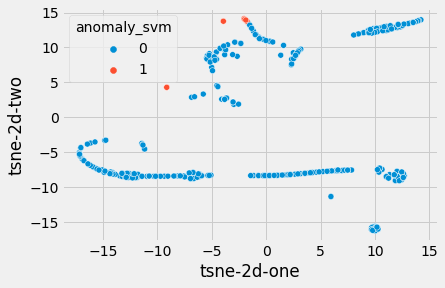

In [214]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_svm",
    data=df,
    legend="full",
    alpha=1
)

In [215]:
df.loc[df['anomaly_svm']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated,anomaly_svm
50,157.55.39.17,47,47.0,47,46,2.907660e+03,4.854550e+03,1638.521739,2,-1.831992,13.868539,4.566288,0,1,1
51,157.55.39.26,58,29.0,58,54,4.883121e+03,6.573502e+03,1149.719298,2,-1.736940,13.663938,4.496382,0,1,1
54,157.55.39.75,64,64.0,64,63,3.828141e+03,4.227239e+03,998.000000,2,-2.040431,14.133765,4.804857,0,1,1
125,195.191.163.28,7,7.0,7,6,7.846000e+07,2.075582e+08,661.166667,4,-9.146929,4.303019,8.750140,1,1,1
136,220.158.157.182,9,9.0,9,4,6.080910e+07,1.824047e+08,17.875000,4,-9.145062,4.293844,7.727056,1,1,1
139,27.65.252.148,6,6.0,6,5,9.153451e+07,2.241887e+08,13.400000,4,-9.151245,4.291281,9.567791,1,1,1
154,40.77.167.35,43,43.0,43,41,2.817860e+03,3.322268e+03,1737.928571,2,-1.757976,13.738455,4.555790,0,1,1
156,40.77.167.38,76,38.0,76,75,3.680197e+03,4.693449e+03,978.480000,2,-1.984128,14.029704,4.584959,0,1,1
159,40.77.167.97,50,50.0,50,47,3.703060e+03,4.927921e+03,1221.061224,2,-1.875208,13.933555,4.599638,0,1,1
227,54.36.148.17,292,146.0,292,292,1.292700e+04,1.491498e+04,306.278351,3,-3.936702,13.761462,19.941191,1,1,1
